## Data Ingestion

In [3]:
import scipy.io as sio

kuka_data = sio.loadmat('../data/KukaDirectDynamics.mat')

In [4]:
print(kuka_data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'kukatraj1', 'kukatraj10', 'kukatraj2', 'kukatraj3', 'kukatraj4', 'kukatraj5', 'kukatraj6', 'kukatraj7', 'kukatraj8', 'kukatraj9'])


## Preprocessing

In [5]:
import numpy as np

trajectories = {}

# filter out non-trajectory keys and prepare data for training
for key, value in kuka_data.items():
    if key.startswith('kukatraj') and isinstance(value, np.ndarray):
        trajectories[key] = value

In [6]:
train_traj_key = 'kukatraj1'
test_traj_key = 'kukatraj2'

train_data = trajectories[train_traj_key]
test_data = trajectories[test_traj_key]

# inputs: joint positions (7), velocities (7), torques (7)
X_train = train_data[:, :21]
# targets: next joint positions (7), next joint velocities (7)
y_train = train_data[:, 21:]

X_test = test_data[:, :21]
y_test = test_data[:, 21:]

print(f"Number of training samples: {X_train.shape[0]}")
print(f"Number of testing samples: {X_test.shape[0]}")
print(f"Number of input features: {X_train.shape[1]}")
print(f"Number of output targets: {y_train.shape[1]}")

Number of training samples: 1814
Number of testing samples: 1857
Number of input features: 21
Number of output targets: 14


# In-depth Evaluation
---

In [10]:
import time
import torch
import sys
sys.path.append('../pc_esn')

import model

overall_start_time = time.time()
trajectory_keys = sorted(list(trajectories.keys()))

# hyperparameters from pc-esn++ implementation
N_RESERVOIR = 400
SPECTRAL_RADIUS = 1.2
SPARSITY = 0.9
LEAK_RATE = 0.25

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("--- PC-ESN++ Evaluation Setup ---")
print(f"Using device: {device}")
if torch.cuda.is_available(): print(f"GPU: {torch.cuda.get_device_name(0)}")
print(f"Trajectories: {len(trajectory_keys)}")
print("-" * 33)

model = model.PC_ESN(n_inputs=21, n_outputs=14, n_reservoir=N_RESERVOIR,
                   spectral_radius=SPECTRAL_RADIUS, sparsity=SPARSITY,
                   leak_rate=LEAK_RATE, device=device)

--- PC-ESN++ Evaluation Setup ---
Using device: cpu
Trajectories: 10
---------------------------------


In [ ]:
import utils

fold_results = []

for i, test_key in enumerate(trajectory_keys):
    fold_start_time = time.time()
    print(f"\n--- Fold {i+1}/{len(trajectory_keys)} ---")
    print(f"Testing on: {test_key}")

    # Data Preparation
    train_keys = [k for k in trajectory_keys if k != test_key]
    train_traj = np.concatenate([trajectories[key] for key in train_keys], axis=0)
    test_traj = trajectories[test_key]

    X_train, y_train = train_traj[:, :21], train_traj[:, 21:]
    X_test, y_test = test_traj[:, :21], test_traj[:, 21:]

    X_train_t = torch.from_numpy(X_train).float().to(device)
    y_train_t = torch.from_numpy(y_train).float().to(device)
    X_test_t = torch.from_numpy(X_test).float().to(device)

    train_time_start = time.time()
    model.train(X_train_t, y_train_t)
    training_time = time.time() - train_time_start
    print(f"Training complete in {training_time:.2f} seconds.")

    # Evaluation
    # Scenario A: Step-by-step prediction
    y_pred_step = model.predict_step_by_step(X_test_t)

    # Scenario B: Full trajectory prediction
    y_pred_full = model.predict_full_trajectory(X_test_t)

    # Calculate Metrics
    nmse_step = utils.nMSE(y_test, y_pred_step)
    nmse_full = utils.nMSE(y_test, y_pred_full)
    euclid_err_step = utils.euclidean_error(y_test, y_pred_step)
    euclid_err_full = utils.euclidean_error(y_test, y_pred_full)

    current_fold_results = {
        'fold': i + 1, 'training_time': training_time,
        'sbs_pos_nmse': np.mean(nmse_step[:7]), 'sbs_vel_nmse': np.mean(nmse_step[7:]),
        'full_pos_nmse': np.mean(nmse_full[:7]), 'full_vel_nmse': np.mean(nmse_full[7:]),
        'sbs_euclid_err': np.mean(euclid_err_step), 'full_euclid_err': np.mean(euclid_err_full),
    }

    # Horizon Analysis
    horizons = sorted(list(set([100, 200, 500, 1000, 1500, y_pred_full.shape[0]-1])))
    for h in horizons:
        nmse_h = utils.nMSE(y_test[:h], y_pred_full[:h])
        euclid_h = utils.euclidean_error(y_test[:h], y_pred_full[:h])
        current_fold_results[f'full_pos_nmse_h{h}'] = np.mean(nmse_h[:7])
        current_fold_results[f'full_euclid_err_h{h}'] = np.mean(euclid_h)

    fold_results.append(current_fold_results)
    print(f"Fold {i+1} evaluation complete. Total time: {time.time() - fold_start_time:.2f}s")

    if i == len(trajectory_keys) - 1:
        last_fold_preds = {'true': y_test, 'step': y_pred_step, 'full': y_pred_full}


--- Fold 1/10 ---
Testing on: kukatraj1
Training complete in 68.21 seconds.
Fold 1 evaluation complete. Total time: 69.50s

--- Fold 2/10 ---
Testing on: kukatraj10
Training complete in 63.53 seconds.
Fold 2 evaluation complete. Total time: 64.91s

--- Fold 3/10 ---
Testing on: kukatraj2
Training complete in 64.02 seconds.
Fold 3 evaluation complete. Total time: 65.33s

--- Fold 4/10 ---
Testing on: kukatraj3
Training complete in 63.04 seconds.
Fold 4 evaluation complete. Total time: 64.46s

--- Fold 5/10 ---
Testing on: kukatraj4
Training complete in 63.13 seconds.
Fold 5 evaluation complete. Total time: 64.49s

--- Fold 6/10 ---
Testing on: kukatraj5
Training complete in 63.42 seconds.
Fold 6 evaluation complete. Total time: 64.77s

--- Fold 7/10 ---
Testing on: kukatraj6
Training complete in 62.85 seconds.
Fold 7 evaluation complete. Total time: 64.26s

--- Fold 8/10 ---
Testing on: kukatraj7
Training complete in 63.51 seconds.
Fold 8 evaluation complete. Total time: 64.90s

--- Fo

In [11]:
import pandas as pd

# Aggregate and Display Final Results
print("\n\n--- Cross-Validation Complete ---")
print(f"Total execution time: {(time.time() - overall_start_time) / 60:.2f} minutes")

results_df = pd.DataFrame(fold_results)
mean_results = results_df.mean()
std_results = results_df.std()

print("\n--- PC-ESN++ Final Averaged Results (Mean ± Std Dev) ---")
print("Metric                      | Mean Value ± Std Deviation")
print("-" * 55)
print(f"Training Time (s)           | {mean_results['training_time']:.2f} ± {std_results['training_time']:.2f}")
print(f"Step-by-Step Pos nMSE       | {mean_results['sbs_pos_nmse']:.4f} ± {std_results['sbs_pos_nmse']:.4f}")
print(f"Step-by-Step Vel nMSE       | {mean_results['sbs_vel_nmse']:.4f} ± {std_results['sbs_vel_nmse']:.4f}")
print(f"Step-by-Step Euclid Err (m) | {mean_results['sbs_euclid_err']:.4f} ± {std_results['sbs_euclid_err']:.4f}")
print(f"Full Traj Pos nMSE          | {mean_results['full_pos_nmse']:.4f} ± {std_results['full_pos_nmse']:.4f}")
print(f"Full Traj Vel nMSE          | {mean_results['full_vel_nmse']:.4f} ± {std_results['full_vel_nmse']:.4f}")
print(f"Full Traj Euclid Err (m)    | {mean_results['full_euclid_err']:.4f} ± {std_results['full_euclid_err']:.4f}")
print("-" * 55)

print("\n--- Error Accumulation Over Prediction Horizon ---")
print("Horizon | Position nMSE       | Op. Space Euclid Err (m)")
print("--------|---------------------|--------------------------")
for h in horizons:
    h_col_pos, h_col_euc = f'full_pos_nmse_h{h}', f'full_euclid_err_h{h}'
    if h_col_pos in mean_results:
        print(f"{h:<8}| {mean_results[h_col_pos]:.4f} ± {std_results[h_col_pos]:.4f}      | {mean_results[h_col_euc]:.4f} ± {std_results[h_col_euc]:.4f}")
print("-" * 55)



--- Cross-Validation Complete ---
Total execution time: 13.43 minutes

--- PC-ESN++ Final Averaged Results (Mean ± Std Dev) ---
Metric                      | Mean Value ± Std Deviation
-------------------------------------------------------
Training Time (s)           | 63.62 ± 1.64
Step-by-Step Pos nMSE       | 1.3022 ± 1.1503
Step-by-Step Vel nMSE       | 0.5615 ± 0.1843
Step-by-Step Euclid Err (m) | 0.3747 ± 0.1499
Full Traj Pos nMSE          | 1.2971 ± 1.0764
Full Traj Vel nMSE          | 0.6229 ± 0.1798
Full Traj Euclid Err (m)    | 0.4364 ± 0.1464
-------------------------------------------------------

--- Error Accumulation Over Prediction Horizon ---
Horizon | Position nMSE       | Op. Space Euclid Err (m)
--------|---------------------|--------------------------
100     | 85826166595.3899 ± 82045956210.8353      | 0.2918 ± 0.1800
200     | 31451367101.1353 ± 79616236266.2967      | 0.2732 ± 0.1867
500     | 649.5541 ± 1660.0208      | 0.2540 ± 0.1170
1000    | 2.4909 ± 2.30

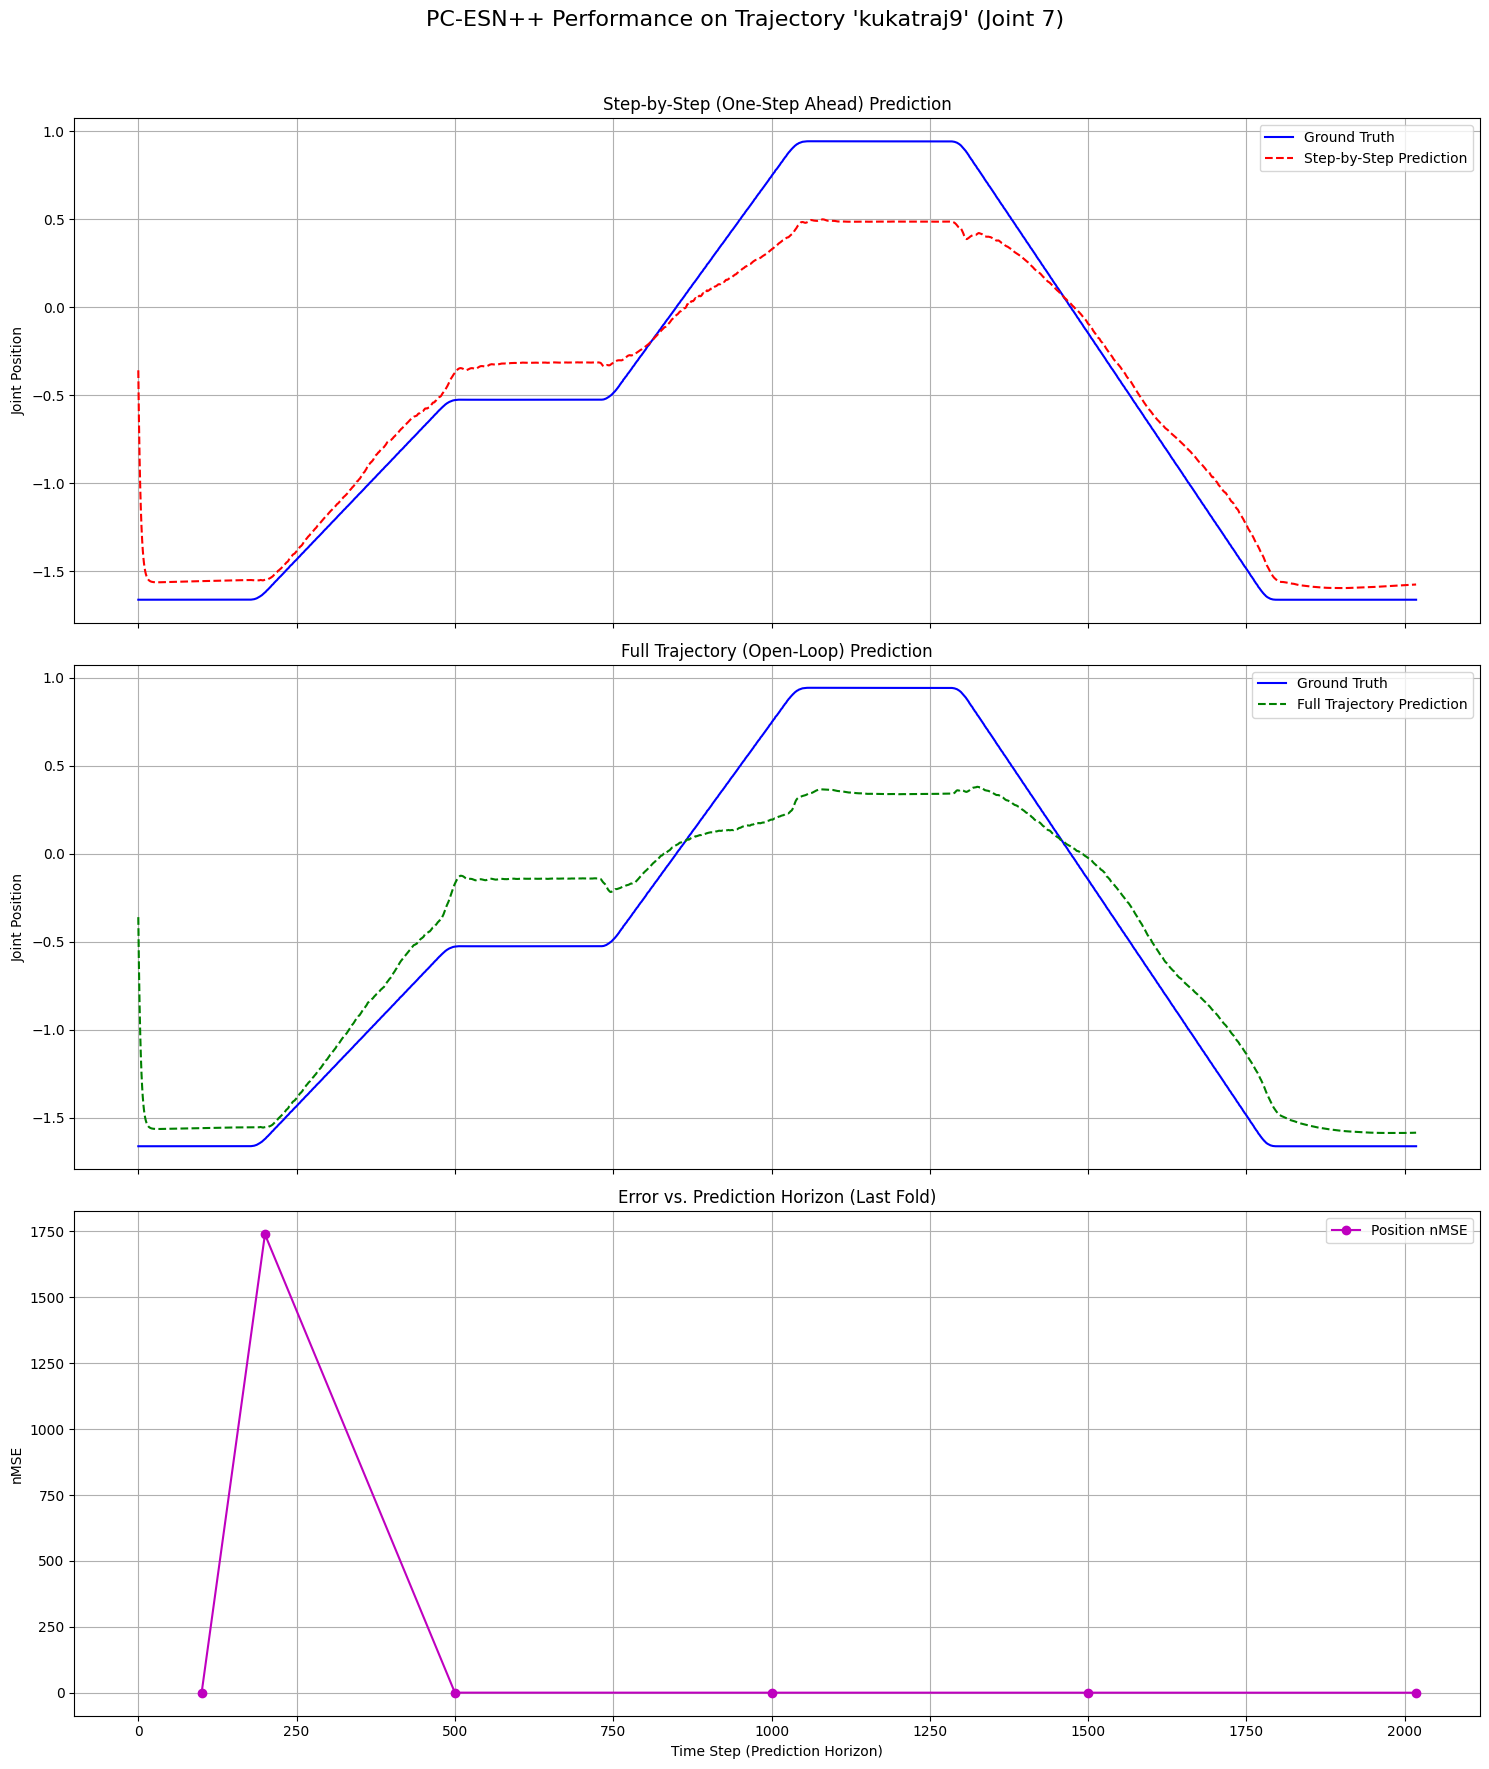

In [12]:
import matplotlib.pyplot as plt

# Visualization (from last fold)
joint_to_plot = 6
y_true_plot = last_fold_preds['true'][:, joint_to_plot]
y_pred_step_plot = last_fold_preds['step'][:, joint_to_plot]
y_pred_full_plot = last_fold_preds['full'][:, joint_to_plot]

fig, axs = plt.subplots(3, 1, figsize=(15, 18), sharex=True)
fig.suptitle(f"PC-ESN++ Performance on Trajectory '{test_key}' (Joint {joint_to_plot+1})", fontsize=16)

axs[0].plot(y_true_plot, 'b-', label='Ground Truth')
axs[0].plot(y_pred_step_plot, 'r--', label='Step-by-Step Prediction')
axs[0].set_title('Step-by-Step (One-Step Ahead) Prediction')
axs[0].set_ylabel('Joint Position'); axs[0].legend(); axs[0].grid(True)

axs[1].plot(y_true_plot, 'b-', label='Ground Truth')
axs[1].plot(y_pred_full_plot, 'g--', label='Full Trajectory Prediction')
axs[1].set_title('Full Trajectory (Open-Loop) Prediction')
axs[1].set_ylabel('Joint Position'); axs[1].legend(); axs[1].grid(True)

horizon_vals = [h for h in horizons if f'full_pos_nmse_h{h}' in results_df.columns]
horizon_errors_pos = [results_df.iloc[-1][f'full_pos_nmse_h{h}'] for h in horizon_vals]
axs[2].plot(horizon_vals, horizon_errors_pos, 'm-o', label='Position nMSE')
axs[2].set_title('Error vs. Prediction Horizon (Last Fold)')
axs[2].set_xlabel('Time Step (Prediction Horizon)'); axs[2].set_ylabel('nMSE'); axs[2].legend(); axs[2].grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()